# Importing Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Load Data

In [4]:
# Builds the data pipeline based on data directory
data = tf.keras.utils.image_dataset_from_directory('data', color_mode='grayscale')
data_iterator = data.as_numpy_iterator()

scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

Found 7624 files belonging to 53 classes.


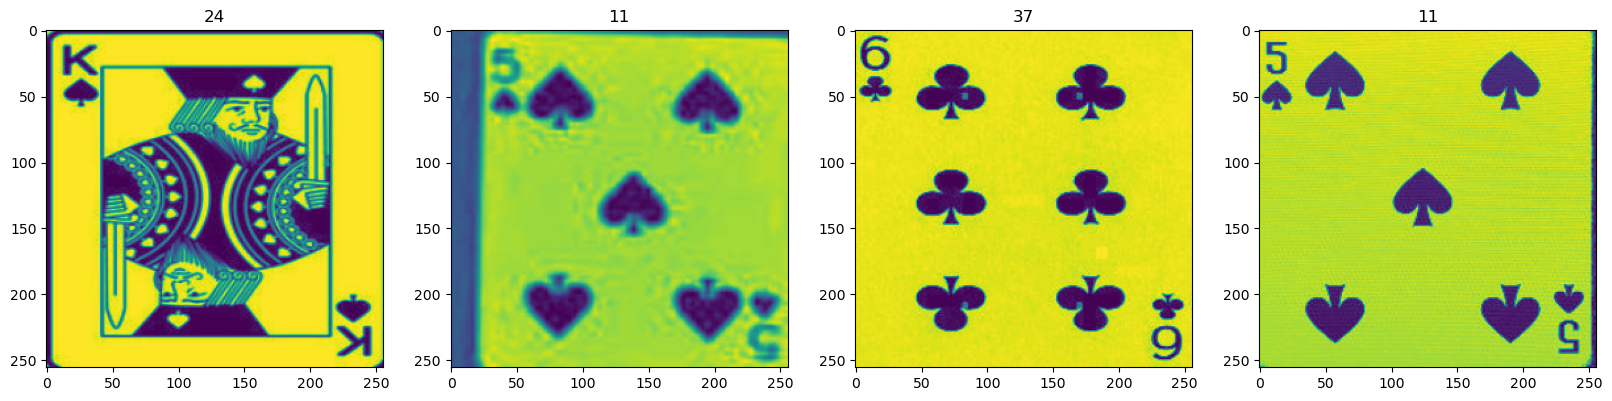

In [5]:
# Before
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# Preprocessing

In [ ]:
# make all images greyscale
path = 'data/'

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.jpg'):
            img_path = os.path.join(root, file)

            with Image.open(img_path) as im:
                im_grayscale = ImageOps.grayscale(im)
                im_grayscale.save(img_path)
            print(f"{img_path} converted to grayscale")

In [6]:
# Scale our data, takes X (the images) and divides it by 255
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[0.89411765],
          [0.89411765],
          [0.89411765],
          ...,
          [0.9254902 ],
          [0.9254902 ],
          [0.9254902 ]],
 
         [[0.89411765],
          [0.89411765],
          [0.89411765],
          ...,
          [0.9296722 ],
          [0.9324602 ],
          [0.935049  ]],
 
         [[0.89142156],
          [0.89361215],
          [0.89411765],
          ...,
          [0.93602943],
          [0.9394608 ],
          [0.94264704]],
 
         ...,
 
         [[0.9490196 ],
          [0.9512102 ],
          [0.95356923],
          ...,
          [0.7666054 ],
          [0.926057  ],
          [0.93063724]],
 
         [[0.9490196 ],
          [0.9484222 ],
          [0.9477788 ],
          ...,
          [0.7784926 ],
          [0.9165135 ],
          [0.9742647 ]],
 
         [[0.9490196 ],
          [0.9458333 ],
          [0.94240195],
          ...,
          [0.9147059 ],
          [0.93284315],
          [0.9647059 ]]],
 
 
        [

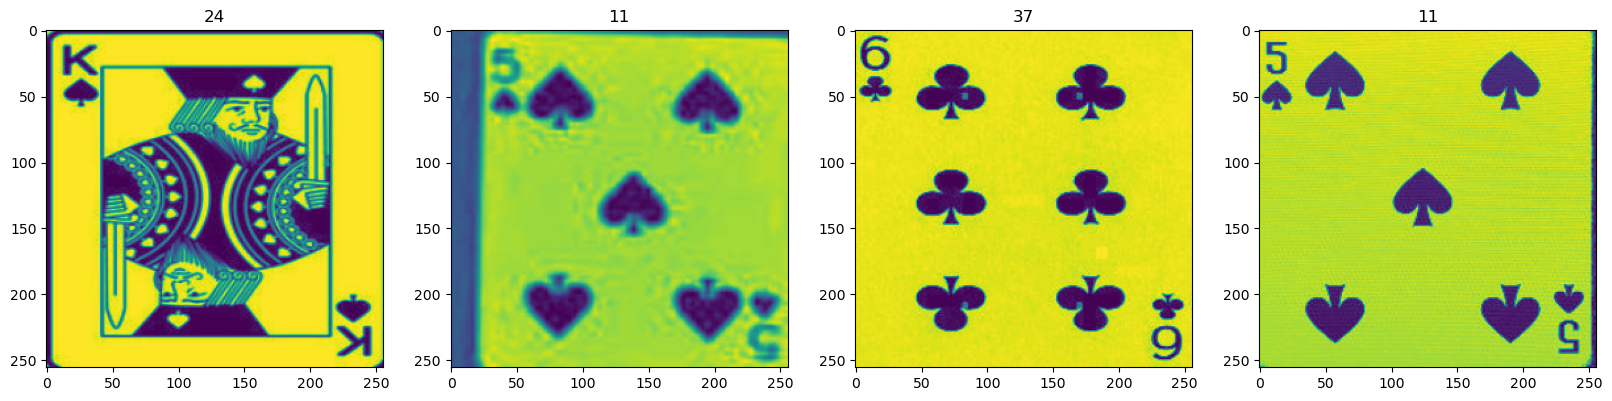

In [7]:
# After
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [8]:
# Allocate data between training, validating, and testing, these should all add up to 239 so we dont lose any data
len(data) # 239

train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.2)

In [9]:
# how many batches do we want to give to our training datat
train = data.take(train_size)
#skip batches that we've allocated to train, take rest to val
val = data.skip(train_size).take(val_size)
#skip all batches we've taken for train and val, take rest to test (everything left over)
test = data.skip(train_size + val_size).take(test_size)

In [10]:
print(f'Training Batches: {len(train)}, Validation Batches: {len(val)}, Testing Batches: {len(test)}')

Training Batches: 167, Validation Batches: 48, Testing Batches: 24


# Model

In [44]:
# Create model using Sequential API
model = Sequential()

# Convolution block 1 (The Input)
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,256,1)))
model.add(MaxPooling2D())

# Convolution block 2
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D())

# Convolution block 3
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())

# Flatten layer
model.add(Flatten())

# Account for dropout
model.add(Dropout(0.2))

# Dense Layers
model.add(Dense(256, activation='relu'))
model.add(Dense(53, activation='softmax'))

In [45]:
model.compile('rmsprop', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 16)      

In [47]:
# creating logs to keep track of training
log_directory = 'logs'

# let tensorboard be able to create logs in that directory
tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_directory)

In [48]:
history = model.fit(train, epochs=50, validation_data=val, callbacks=[tb_callback])

Epoch 1/50
167/167 [==============================] - 43s 254ms/step - loss: 6.0842 - accuracy: 0.1151 - val_loss: 6.8525 - val_accuracy: 0.1491
Epoch 2/50
167/167 [==============================] - 42s 248ms/step - loss: 3.6253 - accuracy: 0.2902 - val_loss: 3.0100 - val_accuracy: 0.3014
Epoch 3/50
167/167 [==============================] - 41s 245ms/step - loss: 3.2012 - accuracy: 0.4798 - val_loss: 2.9588 - val_accuracy: 0.4095
Epoch 4/50
167/167 [==============================] - 40s 237ms/step - loss: 2.3910 - accuracy: 0.6476 - val_loss: 3.0896 - val_accuracy: 0.4759
Epoch 5/50
167/167 [==============================] - 41s 244ms/step - loss: 1.0310 - accuracy: 0.7534 - val_loss: 3.0571 - val_accuracy: 0.4733
Epoch 6/50
167/167 [==============================] - 40s 240ms/step - loss: 0.9320 - accuracy: 0.8271 - val_loss: 3.2793 - val_accuracy: 0.5215
Epoch 7/50
167/167 [==============================] - 39s 232ms/step - loss: 0.5109 - accuracy: 0.8847 - val_loss: 4.1601 - val_ac

In [36]:
history.history

{'loss': [3.103339433670044,
  1.656815528869629,
  0.7921515107154846,
  0.3257386088371277,
  0.18264642357826233,
  0.11889678984880447,
  0.11711163073778152,
  0.09863259643316269,
  0.06423521786928177,
  0.04247797280550003,
  0.03599286079406738,
  0.04855617880821228,
  0.05503632873296738,
  0.04901551827788353,
  0.05437343195080757,
  0.03046591207385063,
  0.018934832885861397,
  0.013826215639710426,
  0.02402563765645027,
  0.02981438674032688],
 'accuracy': [0.22024700045585632,
  0.5668038725852966,
  0.7866766452789307,
  0.921407163143158,
  0.9597679376602173,
  0.9777320623397827,
  0.9796032905578613,
  0.9814745783805847,
  0.988772451877594,
  0.9917664527893066,
  0.99382483959198,
  0.991205096244812,
  0.9902694821357727,
  0.9904565811157227,
  0.9917664527893066,
  0.9958832263946533,
  0.996444582939148,
  0.9971930980682373,
  0.994947612285614,
  0.9945733547210693],
 'val_loss': [2.338632106781006,
  1.9704228639602661,
  2.0939693450927734,
  2.2912032

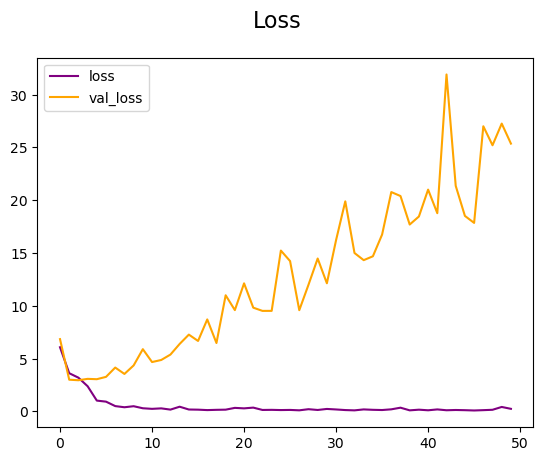

In [49]:
# Plotting Training loss over Value loss
fig = plt.figure()
plt.plot(history.history['loss'], color='purple', label='loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize =16)
plt.legend(loc='upper left')
plt.show()

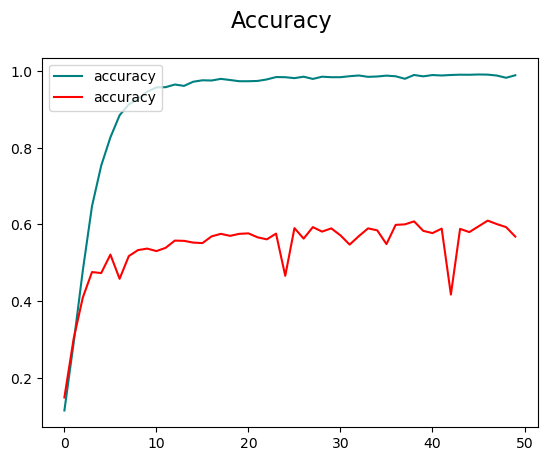

In [50]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'accuracy')
fig.suptitle('Accuracy', fontsize =16)
plt.legend(loc='upper left')
plt.show()

# Evaluating Performance

In [51]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [53]:
len(test)

24

In [54]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yHat_probabilities = model.predict(X)
    
    # Convert probabilities to binary predictions by taking the index of the maximum probability
    yHat = np.argmax(yHat_probabilities, axis=1)
    
    precision.update_state(y, yHat)
    recall.update_state(y, yHat)
    accuracy.update_state(y, yHat)

1/1 [==============================] - 0s 120ms/step


In [57]:
# print results of the model
print(f'Precision: {precision.result()}, Recall: {recall.result()}, Accuracy: {accuracy.result()}')

Precision: 0.9958847761154175, Recall: 0.9931600689888, Accuracy: 0.032258063554763794


# Testing

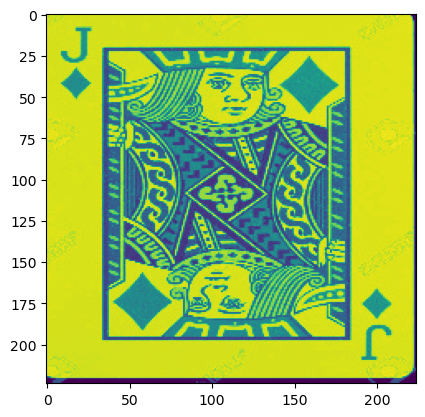

In [67]:
# Take in data that the model has never seen before
img = cv2.imread('test/jack of diamonds/5.jpg')
gray_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image)
plt.show()

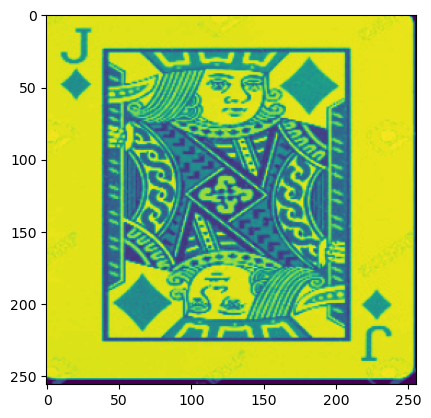

In [77]:
#Clean up the data
gray_image_with_batch = tf.expand_dims(gray_image, axis=-1)
resize = tf.image.resize(gray_image_with_batch, (256,256))


plt.imshow(tf.squeeze(resize).numpy().astype(int))
plt.show()

In [78]:
# expects batch, expand dims allows to only input one image 
yHat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 39ms/step


In [84]:
class_lables = []
for folders in os.listdir('data/'):
    if os.path.isdir(os.path.join('data/', folders)):
        class_lables.append(folders)
print(class_lables)

['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


In [85]:
# Get the index of the class with the highest probability for each sample in the batch
predicted_classes = np.argmax(yHat_probabilities, axis=1)

predicted_classes_lables = [class_lables[i] for i in predicted_classes]
# Print the predicted classes
print("Predicted classes:", predicted_classes_lables)

Predicted classes: ['king of diamonds', 'two of spades', 'three of hearts', 'queen of diamonds', 'two of diamonds', 'queen of diamonds', 'ten of spades', 'jack of diamonds']


# Save the model

In [89]:
model.save(os.path.join('models', 'card_image_classifier_model.h5'))

In [90]:
new_model=load_model(os.path.join('models','card_image_classifier_model.h5'))

In [91]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 79ms/step


array([[0.00885345, 0.06092003, 0.06785461, 0.04039672, 0.00975458,
        0.020065  , 0.01723336, 0.00952115, 0.00829543, 0.07709805,
        0.00379207, 0.02831576, 0.00841527, 0.02844093, 0.02631134,
        0.00392054, 0.00524204, 0.014804  , 0.02698991, 0.00959824,
        0.00745916, 0.00360565, 0.01019114, 0.01077709, 0.02078375,
        0.00884169, 0.01635774, 0.00835595, 0.01085388, 0.01578952,
        0.02738126, 0.00924771, 0.02585835, 0.00758911, 0.01706963,
        0.02390339, 0.02058026, 0.00769153, 0.01529178, 0.0058618 ,
        0.0036524 , 0.01090818, 0.0203379 , 0.00961402, 0.00506128,
        0.01870564, 0.08845209, 0.01674752, 0.01996234, 0.01230611,
        0.02320294, 0.0079407 , 0.01379605]], dtype=float32)

In [92]:
# Get the index of the class with the highest probability for each sample in the batch
predicted_classes_new = np.argmax(yHat_probabilities, axis=1)

predicted_classes_lables_new = [class_lables[i] for i in predicted_classes]
# Print the predicted classes
print("Predicted classes:", predicted_classes_lables_new)

Predicted classes: ['king of diamonds', 'two of spades', 'three of hearts', 'queen of diamonds', 'two of diamonds', 'queen of diamonds', 'ten of spades', 'jack of diamonds']
